# Cancer Detection with Keras

This notebook explores the use of Convolutional Neural Networks (CNNs) to identify malignant cancers in histopathologic scans of lymph node sections. The data is provide by Kaggle as a slightly modified version of the PatchCamelyon (PCam) benchmark dataset.

The dataset consists of a pre-split training and testing set, each with a CSV containing file ids and their labels (0: benign, 1: malignant) and a directory of 96 x 96 pixel RGB TIFF images.

The task is to predict the probability that the center 32x32 pixel region contains at least one pixel of tumor tissue. 

In [1]:
import tensorflow as tf
from tensorflow import data as tf_data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras import layers
import keras_tuner as kt
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.special import expit
import glob
import tifffile as tiff

sns.set(style='whitegrid')
print("Tensorflow version " + tf.__version__)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Tensorflow version 2.17.1


In [2]:
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
train_labels_filepath = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
test_labels_filepath = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'

In [3]:
train_labels = pd.read_csv(train_labels_filepath)
test_labels = pd.read_csv(test_labels_filepath)
train_labels['path'] = train_dir + "/" + train_labels['id'].astype(str) + ".tif"
test_labels['path'] = test_dir + "/" + test_labels['id'].astype(str) + ".tif"

## Exploratory Data Analysis
Here I explore the training and test datasets to understand 
- the data structure
- the relative number of images for each label class
- visualize examples from each class

In [4]:
train_labels.head()

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


In [5]:
# Compare training labels and number of images
num_labels_train = train_labels.shape[0]
num_images_train = len(os.listdir(train_dir))
print(f'Training data contains {num_images_train} with {num_labels_train} labels.')

# Compare test labels and number of images
num_labels_test = test_labels.shape[0]
num_images_test = len(os.listdir(test_dir))
print(f'Training data contains {num_images_test} with {num_labels_test} labels.')

Training data contains 220025 with 220025 labels.
Training data contains 57458 with 57458 labels.


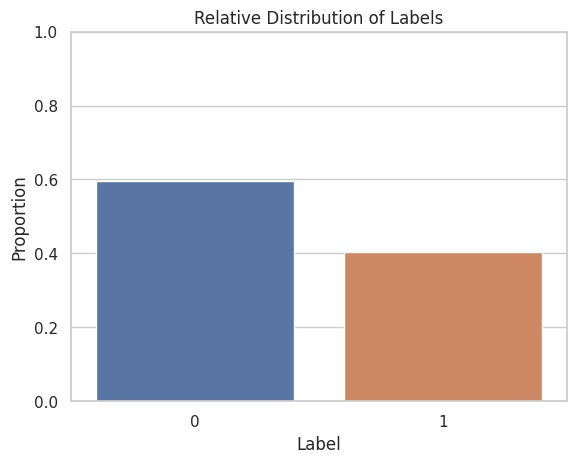

In [6]:
# Count labels in each class
label_counts = train_labels['label'].value_counts(normalize=True).reset_index()
label_counts.columns = ['label', 'proportion']

# Visualize class distribution
sns.barplot(data=label_counts, x='label', y='proportion')

plt.title('Relative Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.show()

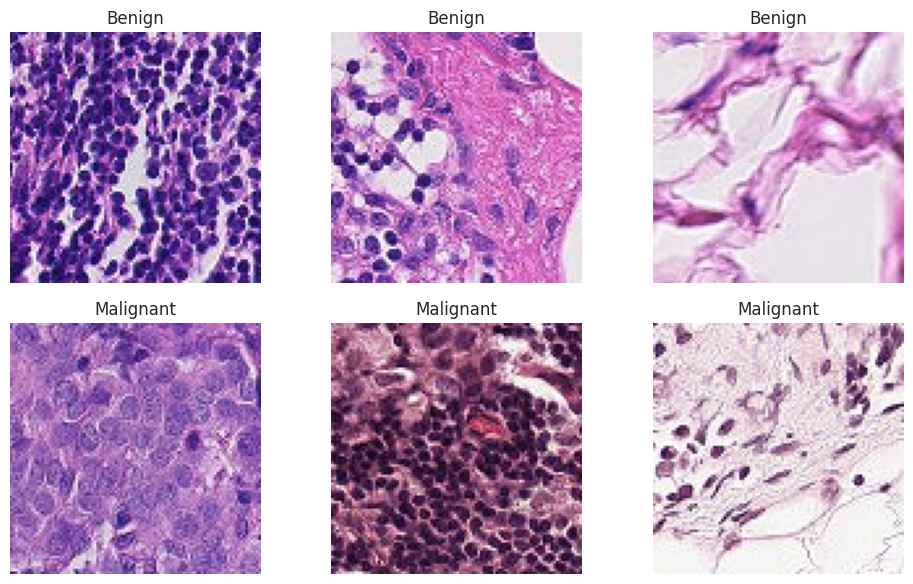

In [7]:
# Visualize benign and malignant samples
benign_samples = train_labels[train_labels["label"] == 0].sample(3)["id"].values
malignant_samples = train_labels[train_labels["label"] == 1].sample(3)["id"].values

fig, axes = plt.subplots(2, 3, figsize=(10,6))

def plot_sample(sample_id, sample_dir, ax, title):
    img_path = os.path.join(sample_dir, sample_id + ".tif")
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title)

for i, img_id in enumerate(benign_samples):
    ax = axes[0, i]
    plot_sample(img_id, train_dir, ax, 'Benign')

for i, img_id in enumerate(malignant_samples):
    ax = axes[1, i]
    plot_sample(img_id, train_dir, ax, 'Malignant')

plt.tight_layout()
plt.show()

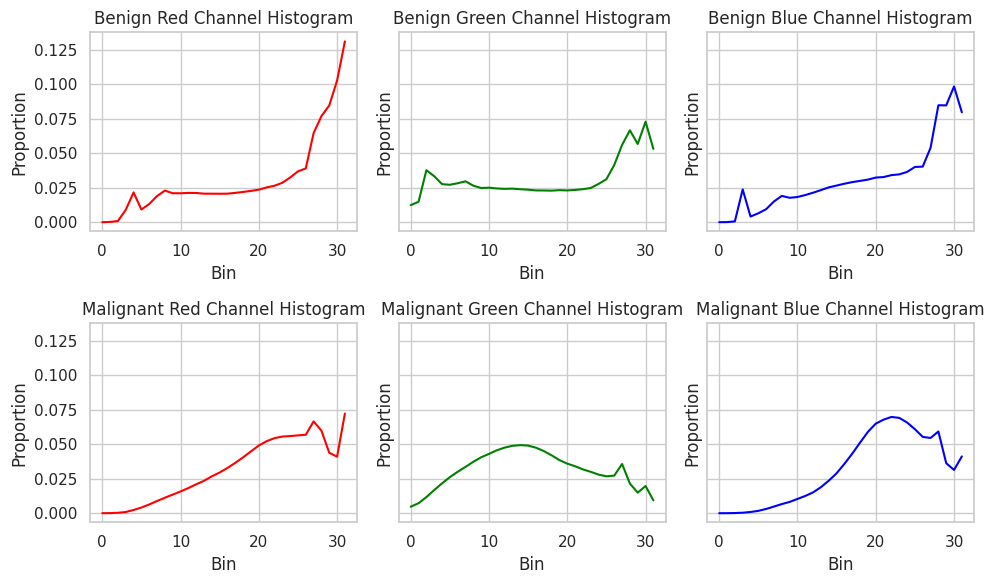

In [8]:
benign_samples = train_labels[train_labels["label"] == 0].sample(100)["id"].values
malignant_samples = train_labels[train_labels["label"] == 1].sample(100)["id"].values
num_bins = 32

histograms = []

def extract_color_histograms(samples, num_bins, label_name):
    # Initialize histograms for each color channel
    hist_r = np.zeros(num_bins)
    hist_g = np.zeros(num_bins)
    hist_b = np.zeros(num_bins)
    
    # Extract and combine data
    for img_id in samples:
        img = cv2.imread(os.path.join(train_dir, img_id + ".tif"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hist_r += cv2.calcHist([img], [0], None, [num_bins], [0, 256]).flatten()
        hist_g += cv2.calcHist([img], [1], None, [num_bins], [0, 256]).flatten()
        hist_b += cv2.calcHist([img], [2], None, [num_bins], [0, 256]).flatten()
        
    # Normalize histograms
    hist_r /= hist_r.sum()
    hist_g /= hist_g.sum()
    hist_b /= hist_b.sum()

    histogram_dict = {'red': hist_r, 'green': hist_g, 'blue': hist_b}
    histograms.append({'label': label_name, 'histograms': histogram_dict})

# Process samples
extract_color_histograms(benign_samples, num_bins, 'Benign')
extract_color_histograms(malignant_samples, num_bins, 'Malignant')

# Plot
fig, axes = plt.subplots(2, 3, figsize=(10,6), sharey=True)

def plot_color_histogram(histogram_values, label, color, ax):
    ax.plot(histogram_values, color=color)
    ax.set_title(f'{label} {color.title()} Channel Histogram')
    ax.set_xlabel('Bin')
    ax.set_ylabel('Proportion')
    ax.grid(True)

for row, result_dict in enumerate(histograms):
    label = result_dict['label']
    histogram_dict = result_dict['histograms']
    for i, color in enumerate(histogram_dict):
        ax = axes[row, i]
        plot_color_histogram(histogram_dict[color], label, color, ax)
        
plt.tight_layout()
plt.show()      

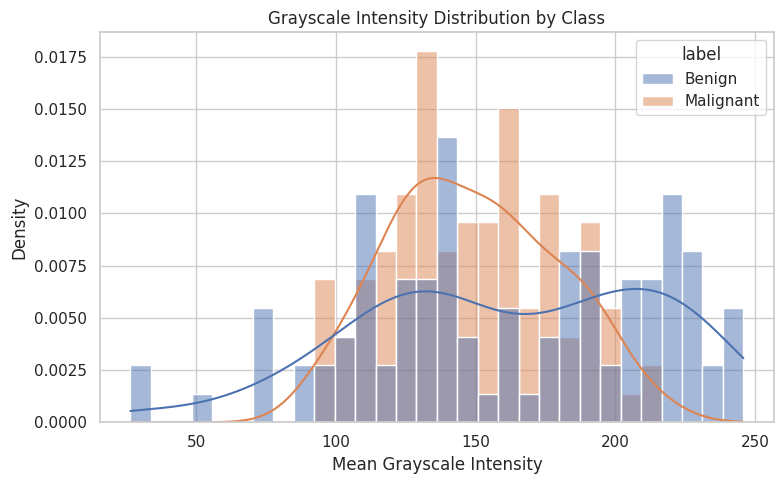

In [9]:
intensities = []

# Function to compute mean grayscale intensity per image
def extract_grayscale_intensity(sample_ids, label_name):
    for img_id in sample_ids:
        img_path = os.path.join(train_dir, img_id + ".tif")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mean_intensity = np.mean(img)
        intensities.append({'label': label_name, 'intensity': mean_intensity})

# Process samples
extract_grayscale_intensity(benign_samples, 'Benign')
extract_grayscale_intensity(malignant_samples, 'Malignant')

# Create DataFrame for Seaborn
df_gray = pd.DataFrame(intensities)

# Plot
plt.figure(figsize=(8, 5))

sns.histplot(data=df_gray, x='intensity', hue='label', kde=True, stat='density', common_norm=False, bins=30)

plt.title('Grayscale Intensity Distribution by Class')
plt.xlabel('Mean Grayscale Intensity')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

## Model Architecture (Analysis Plan)
Having explored the data and a few simple features including RBG histograms and greyscale intensities, we can see that the malignant and benign slides may be difficult to distinguish with traditional machine learning techniques. Therefore, my plan is to use a CNN to attempt to classify images. CNN may work better as it can more easily identify shape-like features in the datasets which may be useful in classifying the images.

Following the Keras tutorial [Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/), I'll train a neural net using the Xception network architecture, which performed well in the tutorial for binary classification of cats and dogs.

I'll then proceed with hyperparameter tuning using [Keras Tuner](https://github.com/keras-team/keras-tuner) for a basic model to compare the Xception architecture with a simpler architecture. Hyperparameters to be tuned will include the number of convolution layers, the sizes of each convolution layer, learning rates, and dropout rates. The intent is to discover a model architecture that is well suited for this problem.

The CNN architecture for all models will include a few important components for this dataset, including:
- Normalizing the data to 0-1 scale from 1-256 pixel values
- Cropping the center of the image to get the middle 32x32 pixels (which is specified as the critical area for the test dataset)

All models will use the Adam optimizer and Binary cross entropy as loss function, which is appropriate for this binary classificaiton task. In the model pipeline, I will also apply data augmentation by rotating and flipping the images

In [10]:
# Balance training data (subsample for debugging)
n_train = train_labels['label'].value_counts().min()
n_train = round(n_train * 0.05)  # Limit to 10% of total for debugging

benign = train_labels[train_labels['label'] == 0].sample(n_train)
malignant = train_labels[train_labels['label'] == 1].sample(n_train)
df_train_all = pd.concat([benign, malignant], axis=0).reset_index(drop=True)

In [11]:
# Split training and testing data
train_df, val_df = train_test_split(
    df_train_all, 
    test_size=0.2, 
    stratify=df_train_all['label'], 
    random_state=1337
)

In [12]:
# Set up TensorFlow Data Service
def make_dataset(df, image_dir, image_size, batch_size, shuffle=True, repeat=True, include_id=False):
    file_paths = df['path'].astype(str).tolist()
    labels = df['label'].tolist()
    ids = df['id'].astype(str).tolist()

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels, ids))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)

    def map_fn(path, label, id_):
        def _load_image(p):
            p = p.numpy().decode("utf-8")
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            return img.astype(np.float32) / 255.0

        image = tf.py_function(_load_image, inp=[path], Tout=tf.float32)
        image.set_shape((*image_size, 3))
        return (image, label, id_) if include_id else (image, label)

    ds = ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)

    if repeat:
        ds = ds.repeat()

    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [13]:
# Create data streams
image_size = (96, 96)
batch_size = 128

train_ds = make_dataset(train_df, train_dir, image_size, batch_size, shuffle=True)
val_ds = make_dataset(val_df, train_dir, image_size, batch_size, shuffle=False)

In [14]:
# Augment data with rotation and flip
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

## Train Xception model

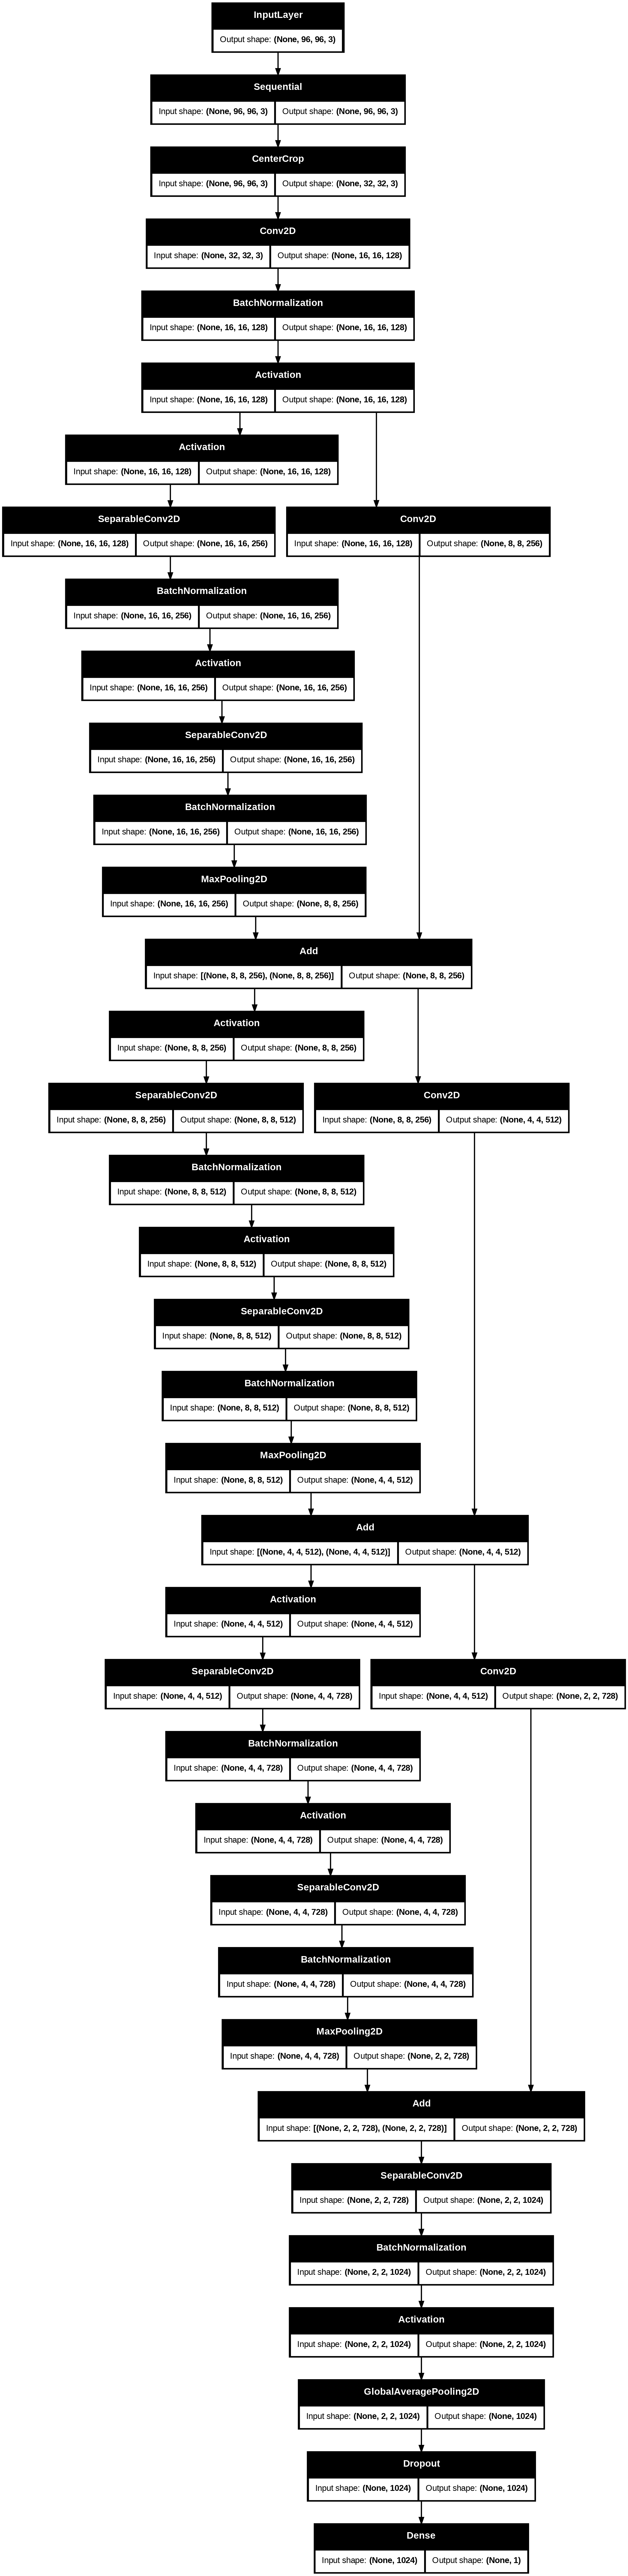

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # x = layers.Rescaling(1./255)(x)
    x = layers.CenterCrop(32, 32)(x)

    # Entry block
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

xception_model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(xception_model, show_shapes=True)

Because the model returns logit rather than 0-1 probabilities, the validation loss is still high when confidence is low, and thus validation accuracy tends to grow very slowly. With early stopping, the training often stops prematurely before sufficient burn in time for weights. I create the MinimumEpochEarlyStopping to overcome this. 

In [16]:
class MinimumEpochEarlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self, min_epochs=10, **kwargs):
        super().__init__(**kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Only start checking for stopping after reaching min_epochs
        if epoch + 1 >= self.min_epochs:
            super().on_epoch_end(epoch, logs)

In [17]:
epochs = 25
steps_per_epoch = int(np.ceil(len(train_df) / batch_size))
validation_steps = int(np.ceil(len(val_df) / batch_size))
    
callbacks = [
    MinimumEpochEarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

In [18]:
xception_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)

history_xception = xception_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 646ms/step - accuracy: 0.7234 - loss: 0.5518 - val_accuracy: 0.4989 - val_loss: 0.6937 - learning_rate: 3.0000e-04
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.7624 - loss: 0.5021 - val_accuracy: 0.5000 - val_loss: 0.6950 - learning_rate: 3.0000e-04
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7665 - loss: 0.4921
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.7665 - loss: 0.4920 - val_accuracy: 0.5011 - val_loss: 0.6960 - learning_rate: 3.0000e-04
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.7750 - loss: 0.4731 - val_accuracy: 0.5000 - val_loss: 0.6947 - learning_rate: 1.5000e-04
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.7909 - loss: 0.4424 - val_accuracy: 0.5000 - val_loss: 0.6912 - learning_rate: 1.5000e-04
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy:

I was able to achieve fairly high training accuracy using the untuned Xception model architecture. Based on hyperparameter tuning (not presented in this notebook) I feel confident that the architecture of Xception is fairly well tuned for this dataset (although of course some additional performance could be squeezed out; as this is a demonstration notebook I don't invest the training time to explore all hyperparameter combinations).

Let's explore a more basic model where hyperparameter tuning is faster to see how well Xception performs relative to a basic architecture.

## Train basic CNN with hyperparameter tuning

In [19]:
def build_basic_model(hp):
    model = keras.Sequential()
    
    model.add(keras.Input(shape=image_size + (3,)))
    # model.add(layers.Rescaling(1./255))
    model.add(layers.CenterCrop(32, 32))

    # Tune number of layers and layer sizes
    for i in range(hp.Int('num_blocks', 1, 3)):
        filters = hp.Choice(f'block_filters_{i}', values=[32, 64, 128])
        model.add(layers.Conv2D(filters, kernel_size=(3, 3), activation="relu"))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    # Tune dropout 
    model.add(layers.Dropout(hp.Choice('dropout', values=[0.2, 0.3, 0.5])))
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile model with variable learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")]
    )

    return model

In [20]:
# Delete the tuner directory if it exists
import shutil
tuner_dir = 'my_tuners/basic'
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

# Initialize tuner
basic_tuner = kt.RandomSearch(
    lambda hp: build_basic_model(hp),
    objective='val_accuracy',
    directory='my_tuners',
    project_name='basic'
)

# Summarize tuner
basic_tuner.search_space_summary()

Search space summary
Default search space size: 4
num_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
block_filters_0 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.5], 'ordered': True}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [21]:
# Run tuner
basic_tuner.search(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    validation_data=val_ds,
)

Trial 10 Complete [00h 02m 30s]
val_accuracy: 0.7594866156578064

Best val_accuracy So Far: 0.7706473469734192
Total elapsed time: 00h 25m 56s


In [22]:
basic_tuner.results_summary()

Results summary
Results in my_tuners/basic
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
num_blocks: 1
block_filters_0: 64
dropout: 0.3
learning_rate: 0.00047660171076051495
Score: 0.7706473469734192

Trial 03 summary
Hyperparameters:
num_blocks: 2
block_filters_0: 32
dropout: 0.2
learning_rate: 0.000742273365279094
block_filters_1: 128
Score: 0.7672991156578064

Trial 05 summary
Hyperparameters:
num_blocks: 1
block_filters_0: 128
dropout: 0.5
learning_rate: 0.000215710835819955
block_filters_1: 128
Score: 0.765625

Trial 08 summary
Hyperparameters:
num_blocks: 2
block_filters_0: 64
dropout: 0.3
learning_rate: 0.0018178305637889431
block_filters_1: 64
block_filters_2: 64
Score: 0.7633928656578064

Trial 07 summary
Hyperparameters:
num_blocks: 2
block_filters_0: 128
dropout: 0.5
learning_rate: 0.0002926126436964912
block_filters_1: 128
block_filters_2: 128
Score: 0.7611607313156128

Trial 01 summary
Hyperparameters:
num_blocks:

In [23]:
# Get the top model
models = basic_tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ center_crop (CenterCrop)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          14,401 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,193 (63.25 KB)

 Trainable params: 16,193 (63.25 KB)

 Non-trainable params: 0 (0.00 B)

The top model architecture for a basic `Sequential` model in `keras` is shown above. 

## Results & Analysis
I'll fit both the basic model and the Xception model to produce submissions for the public leaderboard so we can compare true performance. I'll also plot training versus validation accuracy over epochs to get a sense of model stability and the AUC-ROC curve as that is the accuracy metric used by the competition.

In [24]:
# Balance training data (subsample for debugging)
n_train = train_labels['label'].value_counts().min()

benign = train_labels[train_labels['label'] == 0].sample(n_train)
malignant = train_labels[train_labels['label'] == 1].sample(n_train)
df_train_all = pd.concat([benign, malignant], axis=0).reset_index(drop=True)

# Split training and testing data
train_df, val_df = train_test_split(
    df_train_all, 
    test_size=0.2, 
    stratify=df_train_all['label'], 
    random_state=1337
)

steps_per_epoch = int(np.ceil(len(train_df) / batch_size))
validation_steps = int(np.ceil(len(val_df) / batch_size))

# Make dataset
train_ds_full = make_dataset(train_df, train_dir, image_size, batch_size, shuffle=True)
val_ds_full = make_dataset(val_df, train_dir, image_size, batch_size, shuffle=False)

In [25]:
# Fit final basic model
best_basic_hps = basic_tuner.get_best_hyperparameters(num_trials=1)
best_basic_model = build_basic_model(best_basic_hps[0])
history_basic = best_basic_model.fit(
    train_ds_full,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    validation_data=val_ds_full  
)

Epoch 1/25
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 707s 633ms/step - accuracy: 0.7288 - loss: 0.5495 - val_accuracy: 0.7567 - val_loss: 0.5047 - learning_rate: 4.7660e-04
Epoch 2/25
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 199s 179ms/step - accuracy: 0.7673 - loss: 0.4949 - val_accuracy: 0.7723 - val_loss: 0.4941 - learning_rate: 4.7660e-04
Epoch 3/25
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 198s 178ms/step - accuracy: 0.7720 - loss: 0.4860 - val_accuracy: 0.7756 - val_loss: 0.4887 - learning_rate: 4.7660e-04
Epoch 4/25
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 216s 194ms/step - accuracy: 0.7754 - loss: 0.4781 - val_accuracy: 0.7845 - val_loss: 0.4688 - learning_rate: 4.7660e-04
Epoch 5/25
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 233s 210ms/step - accuracy: 0.7827 - loss: 0.4696 - val_accuracy: 0.7857 - val_loss: 0.4725 - learning_rate: 4.7660e-04
Epoch 6/25
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7838 - loss: 0.4651
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000238300854107365.
1114/1114 ━━━━━━━━━━━━━━━

In [26]:
# Fit Xception model to all data
history_xception = xception_model.fit(
    train_ds_full,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    validation_data=val_ds_full,
)

Epoch 1/25
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 242s 216ms/step - accuracy: 0.8098 - loss: 0.4115 - val_accuracy: 0.7268 - val_loss: 0.4836 - learning_rate: 3.7500e-05
Epoch 2/25
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 241s 216ms/step - accuracy: 0.8207 - loss: 0.3862 - val_accuracy: 0.7584 - val_loss: 0.4694 - learning_rate: 3.7500e-05
Epoch 3/25
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 226s 203ms/step - accuracy: 0.8259 - loss: 0.3775 - val_accuracy: 0.8191 - val_loss: 0.3811 - learning_rate: 3.7500e-05
Epoch 4/25
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 309s 277ms/step - accuracy: 0.8288 - loss: 0.3699 - val_accuracy: 0.7664 - val_loss: 0.4484 - learning_rate: 3.7500e-05
Epoch 5/25
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8321 - loss: 0.3637
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 290s 261ms/step - accuracy: 0.8321 - loss: 0.3637 - val_accuracy: 0.7324 - val_loss: 0.4994 - learning_rate: 3.7500e-05
Epoch 6/25
1114/1114 ━━━━━━━━━━━━━

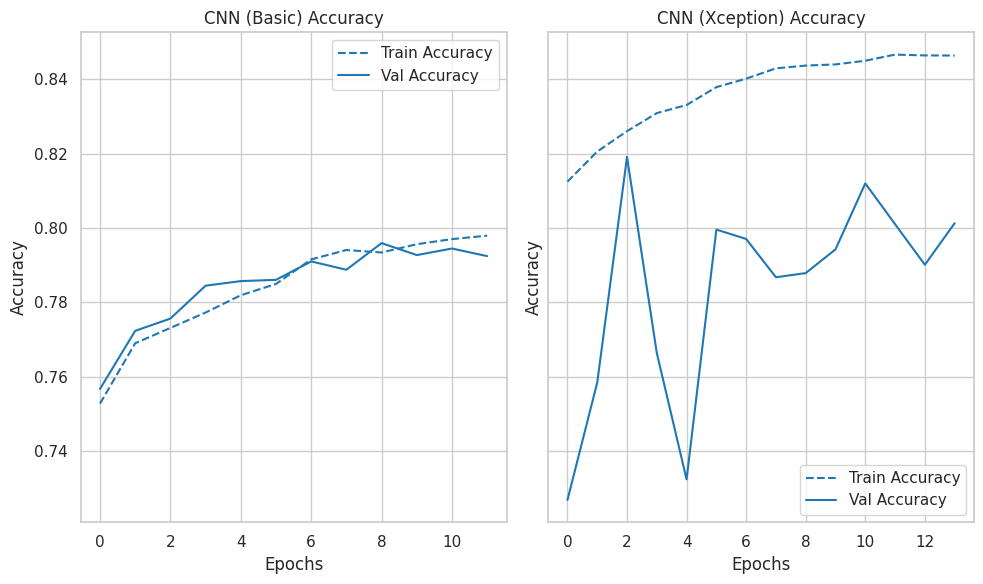

In [27]:
def plot_accuracy(model, ax, title):
    ax.plot(model.history['accuracy'], label='Train Accuracy', color='#1f77b4', linestyle='dashed')
    ax.plot(model.history['val_accuracy'], label='Val Accuracy', color='#1f77b4')
    ax.set_title(f'CNN ({title}) Accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Plot history_basic
plot_accuracy(history_basic, axes[0], "Basic")
plot_accuracy(history_xception, axes[1], "Xception")

plt.tight_layout()
plt.show()

In [28]:
# Get true and predicted labels
y_true = np.concatenate([y.numpy() for _, y in val_ds.take(validation_steps)], axis=0)
y_pred_basic = best_basic_model.predict(val_ds, steps=validation_steps).ravel()
y_pred_xception = xception_model.predict(val_ds, steps=validation_steps).ravel()

279/279 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step
279/279 ━━━━━━━━━━━━━━━━━━━━ 36s 127ms/step


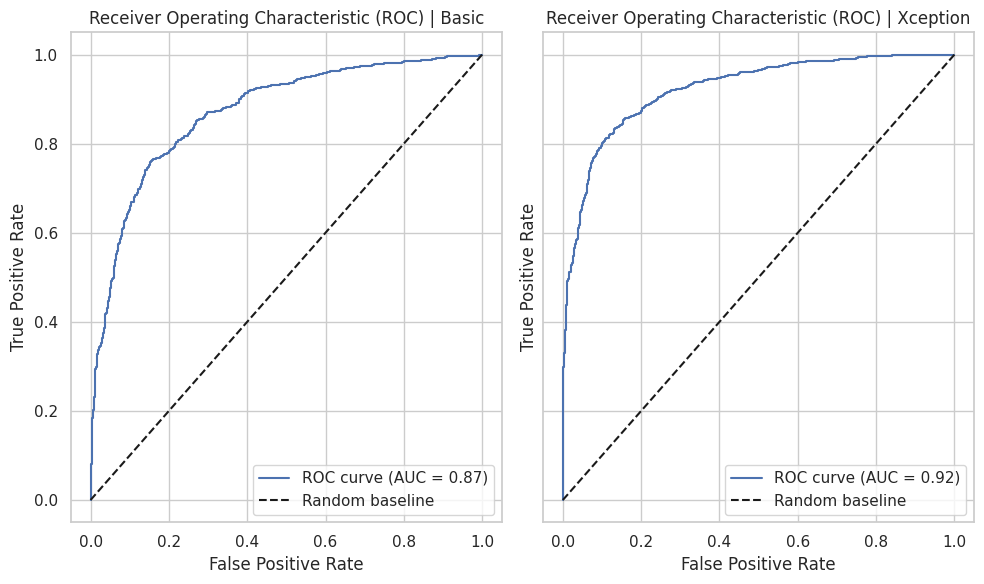

In [29]:
def plot_roc(y_true, y_pred, ax, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random baseline")
    ax.set_title(f"Receiver Operating Characteristic (ROC) | {title}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Plot
plot_roc(y_true, y_pred_basic, axes[0], "Basic")
plot_roc(y_true, y_pred_xception, axes[1], "Xception")

plt.tight_layout()
plt.show()

We can see that the best basic model performed fairly well and was able to stablize training in the first few epochs for both training and validation sets. Training and validation accuracies are similar which indicates low likelihood of overfitting. In comparison, the Xception model struggled to stabilize around the validation set which may indicate an issue with the learning rate or validation sets. The low validation rate and steep climb after 8 epochs is also of note, but may be due to using logits rather than probabilities as output for that model. 

## Create Submission
I'll create a submission for both the Xception model and basic model using the test dataset.

In [30]:
# Create test data stream
test_ds = make_dataset(test_labels, test_dir, image_size, batch_size, 
                       shuffle=False, repeat=False, include_id=True)

# Strip out the IDs for prediction
predict_ds = test_ds.map(lambda image, label, id_: image)

In [31]:
all_ids = []
for batch in test_ds:
    _, _, ids = batch
    all_ids.extend([id_.numpy().decode("utf-8") for id_ in ids])
len(all_ids)

57458

In [32]:
# Create submission
y_pred_basic = best_basic_model.predict(predict_ds).ravel()
submission_basic_df = pd.DataFrame(
    {
        'id': all_ids,
        'label': y_pred_basic
    }
)
submission_basic_df.to_csv('submission_basic.csv', index=False)

449/449 ━━━━━━━━━━━━━━━━━━━━ 52s 114ms/step


In [33]:
y_pred_xception = xception_model.predict(predict_ds).ravel()
y_pred_xception_probs = expit(y_pred_xception)
submission_xception_df = pd.DataFrame(
    {
        'id': all_ids,
        'label': y_pred_xception_probs
    }
)
submission_xception_df.to_csv('submission_xception.csv', index=False)

449/449 ━━━━━━━━━━━━━━━━━━━━ 56s 123ms/step


## Conclusion
The basic model architecture was surprisingly competitive with the more complex Xception model architecture. The complexity of the Xception model may have resulted in some unstable behavior as the validation accuracy never settled during training. 

As an aside, I invested heavily in developing a data streaming pipeline that would work efficiently for TIFF data in an interest in reusing this pipeline for more data intensive tasks. It certainly would have been feasible to either copy and convert all of the data to a file format supported by Keras for image processing or even read the data into memory, which would have allowed more time for hyperparameter tuning.

Future directions may be to test other model architectures like Resnet which seemed to work well for others and ensemble multiple models. I would also invest more in debugging the unstable validation error for the Xception model.

## References
- https://keras.io/getting_started/intro_to_keras_for_engineers/
- https://keras.io/examples/vision/image_classification_from_scratch/
- https://keras.io/examples/vision/mnist_convnet/
- https://keras.io/keras_tuner/getting_started/
- https://www.tensorflow.org/tutorials/load_data/images